# GNN

Dieses Notebook ist ein erster Test des GNN Ansatzes für die Vorhersage von $\mu$ und $\sigma$

In [1]:
# Set Notebook Name for WandB
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'gnn.ipynb'
import sys
sys.path.append('../utils')

In [2]:
from helpers import load_data, load_stations, clean_data, normalize_data, create_data, visualize_graph, visualize_attention

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCN, GCNConv, GATConv, GATv2Conv, Sequential, summary, MLP, BatchNorm, GraphSAGE, ResGatedGraphConv, GINConv, GINEConv
from torch_geometric.utils import to_networkx
from torch.nn import Linear, Embedding, Dropout, ModuleList
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from tqdm import tqdm, trange

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopy.distance
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch_geometric
import torch.nn.functional as F
import wandb

%matplotlib inline
plt.style.use('default')

## Import of Data

In [3]:
# Get Data from feather
data = load_data(indexed=False)

# This needs to be done here because we need all stations
#stations = load_stations(data)
#dist_matrix = compute_dist_matrix(stations)
#np.save(dist_matrix, 'dist_matrix.npy')

# Clean Data
data = clean_data(data, max_missing=121, max_alt=1000.0)
# Normalize Data
normalized_data = normalize_data(data, last_obs=-365, method="max") #last_obs is -365 since the last year is used for testing

# Get List of stations with all stations -> will break further code if cut already
stations = load_stations(data)

## Create the torch dataset

The Dataset which is a `pandas.DataFrame` gets converted to a `torch_geometric.data` object, which then can be processed by the GNN

#### ⚠️ TODO



In [7]:
# TODO set the maximum distance (might want to get this from a configuration file)
max_dist = 50
dist_matrix = np.load('dist_matrix.npy')


torch_data = []
for date in tqdm(data['date'].unique()):
    torch_data.append(create_data(df=normalized_data, date=date, dist_matrix=dist_matrix, method='nearest_k', k=5))

100%|██████████| 3530/3530 [00:46<00:00, 75.93it/s]


### Dataloaders

In [8]:
print(len(torch_data))

3530


In [9]:
# TODO another hyperparameter here
BS = 8 #265

# Definition of train_loader and valid_loader
#train_loader_small = DataLoader(torch_data[:365], batch_size=BS, shuffle=True, num_workers=4)
train_loader_full = DataLoader(torch_data[:-365], batch_size=BS, shuffle=True, num_workers=4)
train_loader = DataLoader(torch_data[:-1460], batch_size=BS, shuffle=True, num_workers=4)
valid_loader = DataLoader(torch_data[-1460:-365], batch_size=BS, shuffle=True, num_workers=4)
test_data = torch_data[-365:]
test_loader = DataLoader(test_data, batch_size=BS, shuffle=False, num_workers=4)

### Visualizations of Graph to test if everything worked fine

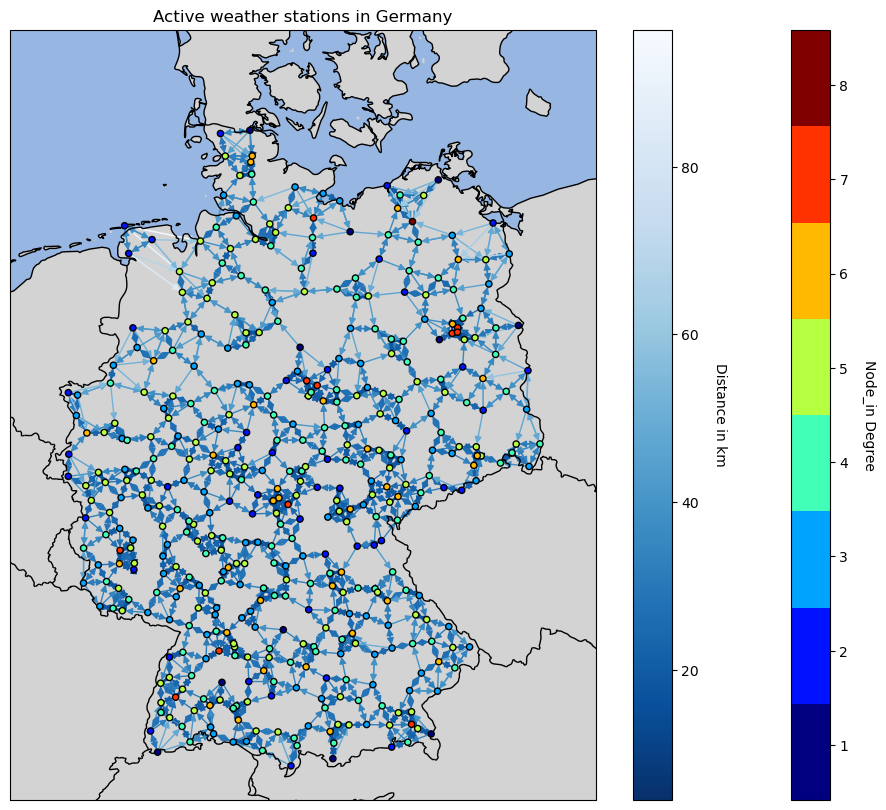

In [10]:
visualize_graph(torch_data[100], stations=stations)

## GNN

In the following section the gnn is constructed. This is largely based on the [PyG Colab Notebooks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing).

#### ⚠️ TODO
 - Modularize -> use multiple torch.modules in a Sequential model
 - Early stopping should save model checkpoint
 - gin config
 - [Neural Tangent Kernel](https://en.wikipedia.org/wiki/Neural_tangent_kernel)
 - Attention weights mitteln und anschauen (Kanten in Graph einfärben)
 - W&B hinzufügen
 - Check out GNN explainer
 - Hyperparameter Optimization
 - Test different Layers and Architectures
    - Embed Node ID (wie in paper von Sebastian)
    - ResNet (Recidual Layer)
    - Softplus for sigma
    - Edge Weights
    - Try Out New Layer Types

### CRPS Loss Function

\begin{align*}

    \operatorname{crps}(F,X)=&\int_{-\inf}^{\inf}\left(F(y)-\boldsymbol{1}_{(y-x)}\right)^2dy\\

\end{align*}

Closed form expression from Gneiting et al. (2005)

\begin{align*}

    \operatorname{crps}\left(\mathcal{N}\left(\mu, \sigma^2\right), y\right)= & \sigma\left\{\frac{y-\mu}{\sigma}\left[2 \Phi\left(\frac{y-\mu}{\sigma}\right)-1\right] +2 \varphi\left(\frac{y-\mu}{\sigma}\right)-\frac{1}{\sqrt{\pi}}\right\}

\end{align*}

$\Phi\left(\frac{y-\mu}{\sigma}\right)$ denotes the CDF of a standard normal distribution and $\varphi\left(\frac{y-\mu}{\sigma}\right)$ denotes the PDF of a standard normal distribution

In [11]:
def crps(mu: torch.tensor, sigma: torch.tensor, y: torch.tensor):
    """Calculates the Continuous Ranked Probability Score (CRPS) assuming normally distributed df

    :param torch.tensor mu: mean
    :param torch.tensor sigma: standard deviation
    :param torch.tensor y: observed df

    :return tensor: CRPS value
    """
    y = y.view((-1,1)) # make sure y has the right shape
    PI = np.pi #3.14159265359
    omega = (y - mu) / sigma
    # PDF of normal distribution at omega
    pdf = 1/(torch.sqrt(torch.tensor(2 * PI))) * torch.exp(-0.5 * omega ** 2)
    
    # Source: https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related
    cdf = 0.5 * (1 + torch.erf(omega / torch.sqrt(torch.tensor(2))))
    
    crps = sigma * (omega * (2 * cdf - 1) + 2 * pdf - 1/torch.sqrt(torch.tensor(PI)))
    return  torch.mean(crps)

### GNN
Definition of Model and Training

In [12]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda', index=1)

In [13]:
class Convolution(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, heads, num_layers:int=None):
        super(Convolution, self).__init__()
        # Make sure either hidden_channels is a list, heads is a list or num_layer is supplied
        assert isinstance(hidden_channels, list) or isinstance(heads, list) or num_layers is not None,\
                "If hidden_channels is not a list, num_layers must be specified."
        # both are a list
        if isinstance(hidden_channels, list) and isinstance(heads, list):
            assert len(hidden_channels) == len(heads), f"Lengths of lists {len(hidden_channels)} and {len(heads)} do not match."
        # only hidden_channels is list
        if isinstance(hidden_channels, list) and not isinstance(heads, list):
            heads = [heads] * len(hidden_channels)
        # only heads is list
        if isinstance(heads, list) and not isinstance(hidden_channels, list):
            hidden_channels = [hidden_channels] * len(heads)
        # none is list
        if not isinstance(heads, list) and not isinstance(hidden_channels, list):
            heads = [heads] * num_layers
            hidden_channels = [hidden_channels] * num_layers
        # definition of Layers
        self.convolutions = ModuleList()
        for c, h in zip(hidden_channels, heads):
            self.convolutions.append(GATConv(in_channels=-1, out_channels=c, heads=h))
        # Last Layer to match shape of output
        self.lin = Linear(in_features=hidden_channels[-1] * heads[-1], out_features=out_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor):
        for conv in self.convolutions:
            x = F.relu(conv(x, edge_index, edge_attr))
        x = self.lin(x)
        return x


class EmbedStations(torch.nn.Module):
    def __init__(self, num_stations_max, embedding_dim):
        super(EmbedStations, self).__init__()
        self.embed = Embedding(num_embeddings=num_stations_max, embedding_dim=embedding_dim)

    def forward(self, x: torch.Tensor):
        station_ids = x[:, 0].long()
        emb_station = self.embed(station_ids)
        x = torch.cat((emb_station, x[:, 1:]), dim=1) # Concatenate embedded station_id to rest of the feature vector
        return x


class MakePositive(torch.nn.Module):
    def __init__(self):
        super(MakePositive, self).__init__()

    def forward(self, x: torch.Tensor):
        mu, sigma = torch.split(x, 1, dim=-1)
        sigma = F.softplus(sigma) # ensure that sigma is positive
        return mu, sigma
    
class ResGnn(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int, hidden_channels: int, heads: int):
        super(ResGnn, self).__init__()
        assert num_layers > 0, "num_layers must be > 0."

        # Create Layers
        self.convolutions = ModuleList()
        for i in range(num_layers):
            self.convolutions.append(GATv2Conv(-1, hidden_channels, heads=heads, edge_dim=1))
        self.norm = BatchNorm(in_channels=hidden_channels*heads)  # TODO bringt das überhaupt was
        self.lin = Linear(hidden_channels * heads, out_channels) #hier direkt 2 testen

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor):
        x = x.float()
        edge_attr = edge_attr.float()
        for i, conv in enumerate(self.convolutions):
            if i == 0:
                # First Layer
                x = conv(x, edge_index, edge_attr)
                x = F.relu(x)
                x = self.norm(x)
            else:
                x = x + F.relu(conv(x, edge_index, edge_attr)) # Residual Layers

        x = self.lin(x)
        return x

    @torch.no_grad()
    def get_attention(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Runs a forward Pass for the given graph only though the ResGNN layer.
        NOTE: the data that is given to this method must first pass through the layers before this layer in the Graph

        :param torch.Tensor x: Tensor of Node Features (NxD)
        :param torch.Tensor edge_index: Tensor of Edges (2xE)
        :param torch.Tensor edge_attr: Edge Attributes (ExNum_Attr)
        :return x, edge_index_attention, attention_weights: Tensor of Node Features (NxD), Tensor of Edges with self loops (2xE), Tensor of Attention per edge (ExNum_Heads)
        """
        x = x.float()
        edge_attr = edge_attr.float()

        # Pass Data though Layer to get the Attention
        attention_list = []
        edge_index_attention, attention_weights = None, None  # Note: edge_index_attention has to be added since we have self loops now

        for i, conv in enumerate(self.convolutions,):
            if i == 0:
                # First Layer
                x, (edge_index_attention, attention_weights) = conv(x, edge_index, edge_attr, return_attention_weights=True)
                attention_list.append(attention_weights)
                x = F.relu(x)
                x = self.norm(x)
            else:
                x_conv, (edge_index_attention, attention_weights) = conv(x, edge_index, edge_attr, return_attention_weights=True)
                attention_list.append(attention_weights)
                x = x + F.relu(x_conv) # Residual Layers
        x = self.lin(x)

        #TODO Average the attention across all layers
        attention_weights = attention_weights.mean(dim=1)

        return x, edge_index_attention, attention_weights


In [ ]:
class GNNOld(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, heads):
        super(GNNOld, self).__init__()
        #self.emb = Embedding(num_embeddings=531, embedding_dim=8)
        self.conv0 = GATConv(num_features, hidden_channels, heads=heads) #Layers mit edge attributes
        self.conv1 = GATConv(-1, hidden_channels, heads=heads)
        self.conv2 = GATConv(-1, hidden_channels, heads=heads)
        self.conv3 = GATConv(-1, hidden_channels, heads=heads)
        self.conv4 = GATConv(-1, hidden_channels, heads=heads)
        self.lin1 = torch.nn.Linear(hidden_channels * heads, 512) #hier direkt 2 testen
        self.lin2 = torch.nn.Linear(512, 2)

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.relu(x)
        x = x + F.relu(self.conv1(x, edge_index)) # Resnet
        x = x + F.relu(self.conv2(x, edge_index)) # Resnet
        x = x + F.relu(self.conv3(x, edge_index)) # Resnet
        x = x + F.relu(self.conv4(x, edge_index)) # Resnet
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        mu, sigma = torch.split(x, 1, dim=-1)
        sigma = F.softplus(sigma) # ensure that sigma is positive
        return mu, sigma

In [14]:
# TODO another parameter
LR = 0.002
EMBED_DIM = 10
Linear_size = 2
hidden_channels = 512
heads = 2
#num_layers = len(heads) if len(heads) > len(hidden_channels) else len(hidden_channels)
num_layers = 2

# Initialize the model and optimizer
num_features = torch_data[0].num_features
emb_num_features = num_features + EMBED_DIM -1

def create_model(EMBED_DIM, emb_num_features, hidden_channels, num_layers, Linear_size, LR):
    # Clear Cache
    torch.cuda.empty_cache()
    #model = GNNOld(num_features=num_features, hidden_channels=16, heads=8)
    model = Sequential('x, edge_index, edge_attr',
                       [
                           (EmbedStations(num_stations_max=535, embedding_dim=EMBED_DIM ), 'x -> x'),

                           #(BatchNorm(in_channels=1), 'edge_attr -> edge_attr'),

                           #(ResGnn(in_channels=-1, out_channels=2, hidden_channels=hidden_channels, heads=heads, num_layers=num_layers), 'x, edge_index, edge_attr -> x'),

                           #(Convolution(in_channels=-1, out_channels=2, hidden_channels=hidden_channels, heads=heads, num_layers=num_layers), 'x, edge_index, edge_attr -> x'),

                           #(lambda edge_attr: edge_attr.flatten(), 'edge_attr -> edge_weight'),

                           (GraphSAGE(in_channels=emb_num_features, hidden_channels=hidden_channels, num_layers=num_layers, out_channels=Linear_size), 'x, edge_index -> x'),

                           #(ResGatedGraphConv(in_channels=-1, out_channels=Linear_size), 'x, edge_index -> x'),

                           #(GINEConv(nn=torch.nn.Sequential(
                           #        torch.nn.Linear(emb_num_features, 512),
                           #        torch.nn.ReLU(),
                           #        torch.nn.Linear(512, 512),
                           #        torch.nn.ReLU(),
                           #        torch.nn.Linear(512, 2)),
                           #    edge_dim=1), 'x, edge_index, edge_attr -> x'),

                           #(Linear(Linear_size, 2),'x -> x'),

                           #(MLP(in_channels=emb_num_features, out_channels=2, hidden_channels=12, num_layers=2),'x -> x'),

                           (MakePositive(), 'x -> mu, sigma')
                       ])

    model.to(device)
    torch_geometric.compile(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #momentum anschauen
    # Learning Rate Scheduler
    scheduler = MultiStepLR(optimizer, milestones=[60, 90, 100, 110], gamma=0.1)
    return  model, optimizer, scheduler

In [15]:
log_WandB = False
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [16]:
#TODO more hyperparams here
n_epochs = 150
patience = 30
n_reps = 1


if log_WandB:
    wandb.init(
    # set the wandb project where this run will be logged
        project="GNNPP",
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": LR,
        "architecture": "ResNetv2",
        "embed_dim": EMBED_DIM,
        "num_layers": num_layers,
        "hidden_channels": hidden_channels,
        "heads": heads,
        "max_epochs": n_epochs,
        "patience": patience,
        "batch_size": BS,
        "max_dist": max_dist
        }
    )


def train(batch):
    batch.to(device)
    optimizer.zero_grad()
    out = model(batch.x, batch.edge_index, batch.edge_attr)
    mu, sigma = out
    loss = crps(mu, sigma, batch.y)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def valid(batch):
    batch.to(device)
    out = model(batch.x, batch.edge_index, batch.edge_attr)
    mu, sigma = out
    loss = crps(mu, sigma, batch.y)
    return loss

model_list = []
train_losses_models = []
validation_losses_models = []

for i in range(n_reps):
    train_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    no_improvement = 0

    # loading bar
    epochs_pbar = trange(n_epochs, desc="Epochs")
    model, optimizer, scheduler = create_model(EMBED_DIM=EMBED_DIM, emb_num_features=emb_num_features, hidden_channels=hidden_channels, num_layers=num_layers, Linear_size=Linear_size, LR=LR)

    for epoch in epochs_pbar:
        # Train for one epoch
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            loss = train(batch)
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluate on the validation set
        model.eval()
        val_loss = 0.0

        for batch in valid_loader:
            loss = valid(batch)
            val_loss += loss.item() * batch.num_graphs
        val_loss /= len(valid_loader.dataset)
        validation_losses.append(val_loss)

        # Log to WandB
        if log_WandB:
            wandb.log({"train_loss": train_loss, "val_loss": val_loss})

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
            # Save model checkpoint
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"checkpoints/checkpoint_model_{i}.pt")
        else:
            no_improvement += 1

        epochs_pbar.set_postfix({"Train Loss": train_loss, "Val Loss": val_loss,"Best Loss": best_val_loss, "No Improvement": no_improvement, "Learning Rate": scheduler.get_last_lr()})
        # Early stopping
        if no_improvement == patience:
            print('Early stopping.')
            break
        # Update the Learning Rate
        scheduler.step()

    if log_WandB:
        wandb.log({"best_val_loss": best_val_loss, "trained_epochs":  epoch-patience})

    # Load weights from model checkpoint
    checkpoint = torch.load(f"checkpoints/checkpoint_model_{i}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Set model to eval mode
    model.eval()
    model_list.append(model)
    train_losses_models.append(train_losses)
    validation_losses_models.append(validation_losses)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]/home/feik/.conda/envs/GNN2/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Epochs:  77%|███████▋  | 115/150 [10:21<03:09,  5.40s/it, Train Loss=0.765, Val Loss=0.797, Best Loss=0.794, No Improvement=30, Learning Rate=[2.0000000000000004e-07]]

Early stopping.


In [17]:
print(summary(model_list[0], x=torch_data[1000].x.to(device), edge_index=torch_data[1000].edge_index.to(device), edge_attr=torch_data[1000].edge_attr.to(device)))

+----------------------------------------+-----------------------+--------------------+----------+
| Layer                                  | Input Shape           | Output Shape       | #Param   |
|----------------------------------------+-----------------------+--------------------+----------|
| Sequential_37e9ba                      |                       | [472, 1], [472, 1] | 60,136   |
| ├─(module_0)EmbedStations              | [472, 42]             | [472, 51]          | 5,350    |
| │    └─(embed)Embedding                | [472]                 | [472, 10]          | 5,350    |
| ├─(module_1)GraphSAGE                  | [472, 51], [2, 1888]  | [472, 2]           | 54,786   |
| │    └─(act)ReLU                       | [472, 512]            | [472, 512]         | --       |
| │    └─(convs)ModuleList               | --                    | --                 | 54,786   |
| │    │    └─(0)SAGEConvJittable_387129 | [472, 51], [2, 1888]  | [472, 512]         | 52,736   |
| │    │  

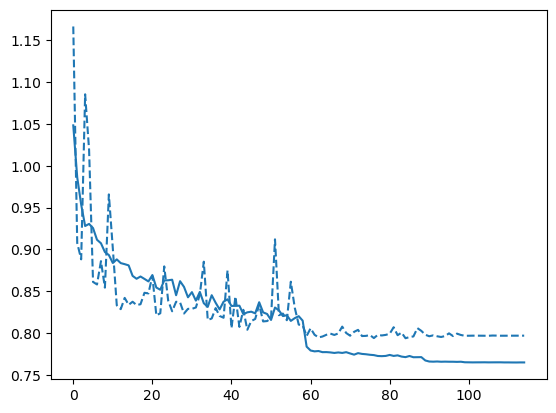

In [18]:
cmap = mpl.colormaps['tab10']
for i, (t, v) in enumerate(zip(train_losses_models, validation_losses_models)):
    plt.plot(t[1:], linestyle='solid', color=cmap(i))
    plt.plot(v[1:], linestyle='dashed',  color=cmap(i))

### Evaluation
Calculation of CRPS on test set and graphical diagnostics

In [19]:
mu_list_model = []
sigma_list_model = []

for model in model_list:
    mu_list_batch = []
    sigma_list_batch = []
    y_list = []

    for batch in test_loader:
        batch.to(device)
        mu, sigma = model(batch.x, batch.edge_index, batch.edge_attr)
        y = batch.y
        y = y.cpu().numpy()
        y_list.append(y)

        mu = mu.detach().cpu().numpy().flatten()
        mu_list_batch.append(mu)
        sigma = sigma.detach().cpu().numpy().flatten()
        sigma_list_batch.append(sigma)


    mu = np.concatenate(mu_list_batch)
    mu_list_model.append(mu)
    sigma = np.concatenate(sigma_list_batch)
    sigma_list_model.append(sigma)
    y = np.concatenate(y_list)
mu = np.array(mu_list_model).T.mean(axis=1).reshape(-1,1)
sigma = np.array(sigma_list_model).T.mean(axis=1).reshape(-1,1)

mu = torch.tensor(mu).to(device)
sigma = torch.tensor(sigma).to(device)
y = torch.tensor(y).to(device)
err = crps(y=y, mu=mu, sigma=sigma)

In [20]:
y = y.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
sigma = sigma.detach().cpu().numpy()

Text(0.5, 1.0, 'Predicted vs. observed temperatures\nCRPS=0.7874')

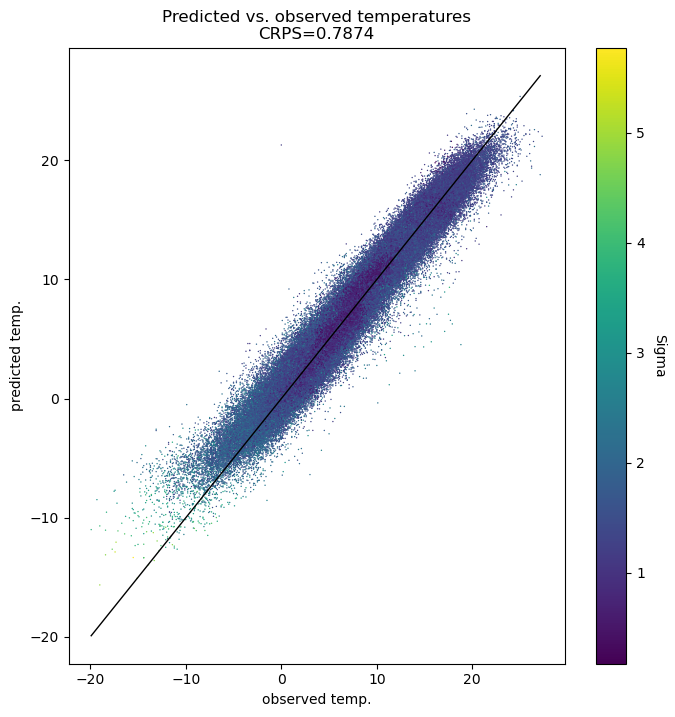

In [21]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap="viridis")

cbar = plt.colorbar()
cbar.set_label('Sigma', rotation=270, labelpad=15)
plt.xlabel('observed temp.')
plt.ylabel('predicted temp.')
plt.title(f"Predicted vs. observed temperatures\nCRPS={err:.4f}")

In [22]:
if log_WandB:
    # save code
    wandb.save("gnn.ipynb")
    wandb.save("helpers.py")
    # finish logging
    wandb.finish()